In [6]:
import pandas as pd
import glob 
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
#import umap
import umap.umap_ as umap
import seaborn as sns
import scipy.stats as sts

from helpers import *

In [7]:
X, y, column_names = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(5)))
column_names

['isbaffled',
 'ip',
 'b0',
 'nel',
 'ptot',
 'pdiv',
 'q95',
 'betan',
 'kappa',
 'deltaavg',
 'deltaupp',
 'deltalow',
 'gapin',
 'gapout',
 'zmag',
 'rmag',
 'rmin',
 'lpar_ot',
 'zeff',
 'LHD_label']

# Visualizing data, looking for patterns or clusters
TSNE is a more traditional approach to dimentionality reduction that somewhat maintains clusters 
It is very costly for high dimensionality datasets and UMAP solves that issue

As stated by the UMAP doc:

**n_neighbors**: This determines the number of neighboring points used in local approximations. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default.

**min_dist**: This controls how tightly the embedding is allowed compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default.
Smaller min_distances are better for clustering
From there we try different UMAP settings

**n_components** parameter option that allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into.

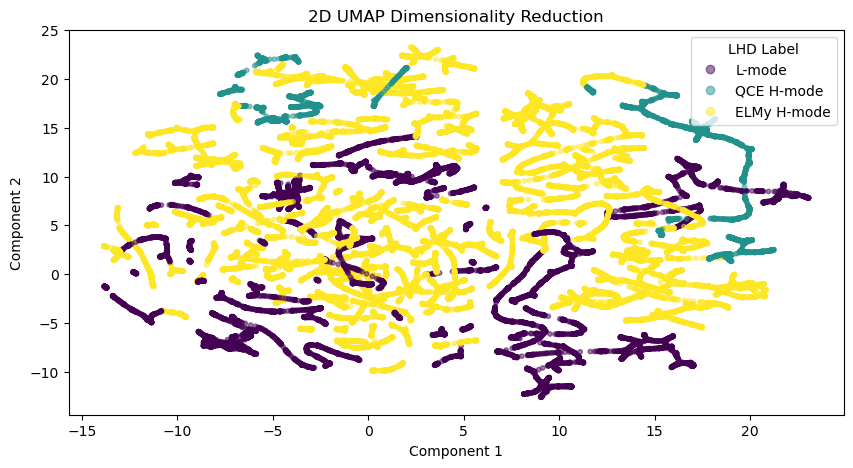

In [8]:
X_umap = perform_umap(X, n_neighbors=40, min_dist=0.1, n_components=2)
draw_reduced_space(X_umap, y, n_components=2, title='2D UMAP Dimensionality Reduction')

Of course we can also plot a third component to get an even better view of the dimensionality reduction!

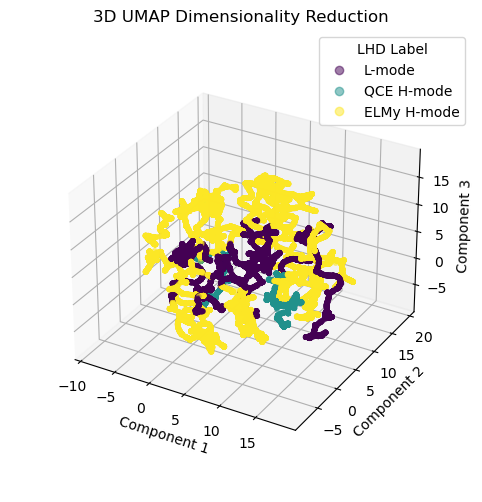

In [9]:
draw_reduced_space(perform_umap(X, n_neighbors=40, min_dist=0.1, n_components=3), y, n_components=3, title='3D UMAP Dimensionality Reduction')

In [12]:
# we build a dataframe with the two main components and the label as columns
df_2_components = pd.DataFrame(
    data=X_umap, 
    columns=['Component1', 'Component2']) 

target_names = {
    1:'L-mode',
    2:'QCE H-mode', 
    3:'ELMy H-mode'
}
df_2_components['LHD label'] = y
df_2_components['LHD label'] = df_2_components['LHD label'].map(target_names)

# Heatmap of Label density in reduced space
Heatmaps help us see in which points of space a label is more likely to be present.

Of course, these visualizations don't take time into account; however, they still reveal that certain zones are more correlated with some LHD labels.

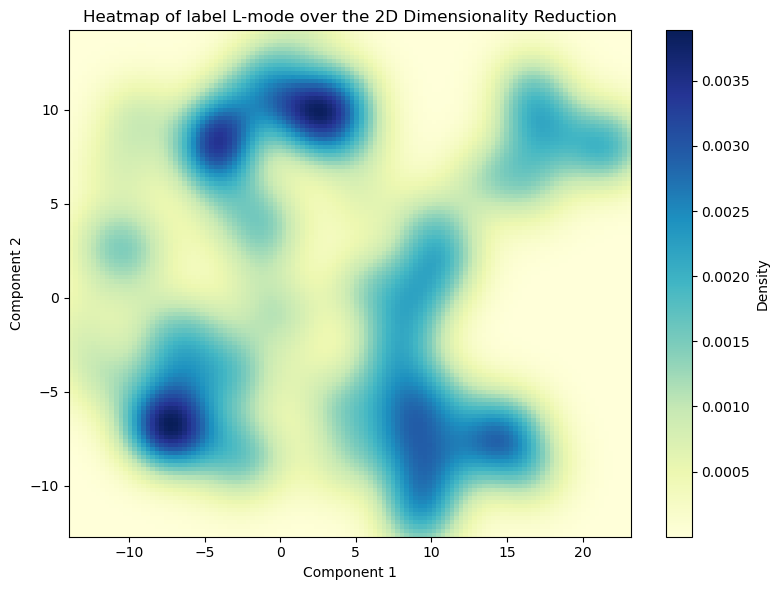

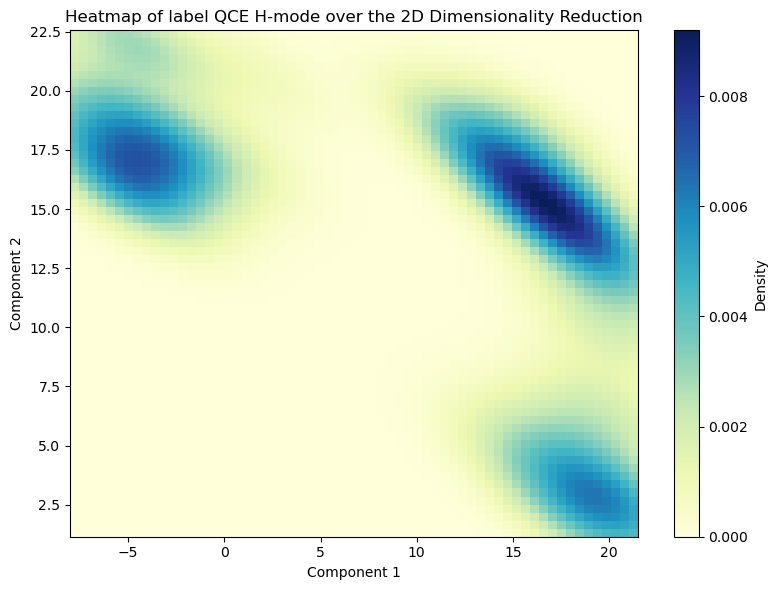

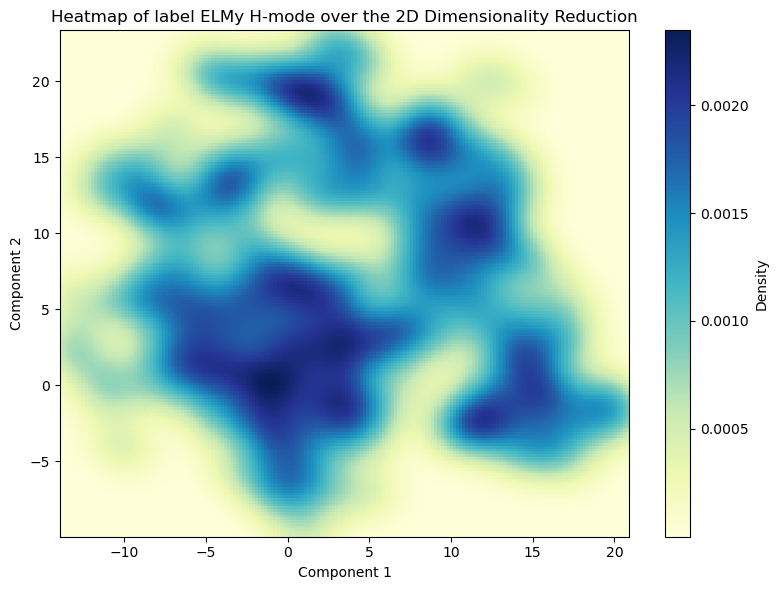

In [15]:
for label in target_names.values():
    pltx = (df_2_components[df_2_components['LHD label'] ==label ])['Component1']
    plty = (df_2_components[df_2_components['LHD label'] ==label ])['Component2']
    k = sts.gaussian_kde([pltx, plty])
    xi, yi = np.mgrid[pltx.min():pltx.max():pltx.size**0.5*1j, plty.min():plty.max():plty.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.YlGnBu)
    plt.colorbar(label='Density')
    plt.title(f'Heatmap of label {label} over the 2D Dimensionality Reduction')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout() 
    plt.show()


## Analysis
With these heatmaps we take every timestep as "independent" without considering the previous steps in the shot. In our next analyses we would like to consider the "history" of a shot.

Indeed, what we are really interested is how and how long it took for a shot to reach a certain point in space. In addition, we want to know how the label evolved as the timeseries happens.

To get answers to these questions we will have to consider time!